# Modified MNIST Challenge
+ Description
+ Dataset
+ Imports
+ Loading
+ Wrangling
+ Splitting
+ TensorFlow ConvNet

## Description
"For project #3, you are asked to create classifiers to analyze images consisting of two digits and a character. The character may be an 'a' or 'A' (for add), in which case your classifier has to return the sum of the two digits, or an 'm' or 'M' (for multiply), in which case your classifier has to return the product of the two digits. Additionally, a variety of different textures are used in the backgrounds of the images.

We provide a set of labeled training data (images and target outputs) as well as a set of unlabeled test data (i.e. images only). You must run your model on the test data and submit the target outputs to Kaggle.

You are allowed to use libraries such as theano/sklearn/tensorflow/pytorch for parts 3 and 1 only. For part 2 you must do the full implementation. You can submit any part for kaggle, although the kaggle competition is ranked based on your best submission only and you have a daily limit on number of submissions.

Please keep the kaggle teams the same as the teams for the report, and include your kaggle team name in the report so we can grade your performance :)"

Original link of the competition (2017-11-13):

## Dataset
The following description from the competition page is available:

"The training set (train_x.csv, test_x.csv) consists of 50,000 8bit-greyscale images of size 64x64. There is a unique label for each of the examples, which is the result of the application of operator on the two digits in the image ( result for "a"/"A" is the sum of two digits and result for "m"/"M" is the product of two digits ). The total num of unique classes are 40 . ( [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 24, 25, 27, 28, 30, 32, 35, 36, 40, 42, 45, 48, 49, 54, 56, 63, 64, 72, 81] )

The test set (test_x.csv) consists of 10000 images of the same format.

The .csv file contains the raw uncompressed images pixel values in row major format separated by ",". Each image is 64 x 64, so each row contains 4096 float values, each containing the a float value which represents the 0-255 greyscale intensity of each pixel."

## Imports

In [63]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import time

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

In [64]:
import platform
print('This notebook was developed in Anaconda using Python', platform.python_version(), 'and TensorFlow',tf.__version__,)

This notebook was developed in Anaconda using Python 3.5.4 and TensorFlow 1.2.1


For replayability only.

In [65]:
SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

## Loading
For this project, we'll be using a modified MNIST dataset obtained from a private Kaggle competition in the course of the third project from McGill's COMP 550 Fall 2017 class.

In [66]:
df_x = pd.read_csv("data/Modified_MNIST/train_x.csv", header=None)
df_y = pd.read_csv("data/Modified_MNIST/train_y.csv", header=None)
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 4096 entries, 0 to 4095
dtypes: float64(4096)
memory usage: 1.5 GB


The data is in type float64 which TensorFlow doesn't like so we'll have to deal with this by casting it down to float32.

## Data Exploration
Let's visualize the dataset and look at some features. Then we can better decide on the model's architecture and get a sense of batch size for training depending on our available computation power. We will also investigate the various distributions in the data.

In [67]:
df_x.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,34.0,35.0,37.0,34.0,42.0,42.0,40.0,43.0,40.0,38.0,...,30.0,40.0,50.0,36.0,36.0,82.0,59.0,32.0,36.0,35.0
1,107.0,97.0,112.0,122.0,123.0,117.0,132.0,137.0,143.0,141.0,...,164.0,170.0,170.0,160.0,166.0,161.0,144.0,138.0,136.0,141.0
2,139.0,135.0,122.0,178.0,162.0,166.0,160.0,154.0,128.0,149.0,...,154.0,142.0,147.0,185.0,158.0,150.0,93.0,104.0,96.0,148.0
3,196.0,195.0,198.0,209.0,206.0,203.0,205.0,197.0,182.0,172.0,...,181.0,181.0,180.0,176.0,170.0,173.0,174.0,167.0,163.0,161.0
4,137.0,145.0,153.0,161.0,168.0,173.0,175.0,178.0,156.0,18.0,...,50.0,54.0,61.0,67.0,74.0,80.0,87.0,91.0,99.0,103.0


### Data Dimensions
Since these values are useful for shapping our tensor variables, we will save them as constants.

In [68]:
IMG_SIZE = 64 # from the description, img is 64x64
IMG_SIZE_FLAT = IMG_SIZE**2 # original img data is a 1-D vector
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) # tuple to shape our tf vars/placeholders
IMG_CHANNELS = 1 # greyscale img
NUM_CLASSES = 40 # number of output classes

### Data Wrangling
We'll now convert our data into a numpy which is easier to work with for machine learning purposes. We will also cast the data to float32 and normalize the features to take values between -1 and 1. Finally, we'll reshape the data into a 4D tensor as defined by the TensorFlow API:

[num_samples, img_height, img_width, img_channels]

For the targets, we'll one hot encode the targets and create a label dictionnary to recover the original label values.

In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#data_x = ((df_x.values.astype('float32') / 128) - 1).reshape(-1, IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
data_x = df_x.values.astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
data_y = df_y.values.flatten()

classes = np.unique(data_y)
labels = dict((i,v) for i,v in enumerate(classes))

label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(data_y).reshape(len(data_y), 1)
onehot_encoder = OneHotEncoder(sparse=False)
y_hot = onehot_encoder.fit_transform(y_int).astype('float32')

### Data Visualization
We'll define a function to draw the input images. This will be useful to compare the model's classification versus the real label. The function will draw 12 images in a 3x4 grid with the true and predicted labels, if available.

In [70]:
def plot_img(images, targets, labels, pred=None):
    PLT_ROWS = 3
    PLT_COLS = 4
    assert len(images) == len(targets) == PLT_ROWS*PLT_COLS
    fig, axes = plt.subplots(PLT_ROWS, PLT_COLS)
    fig.subplots_adjust(hspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(IMG_SHAPE), cmap='gray', vmin=-1, vmax=1)
        
        if pred:
            xlabel = "True: {0}, Pred: {1}".format(labels[targets[i]], labels[pred[i]])
        else:
            xlabel = "True: {0}".format(labels[targets[i]])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show

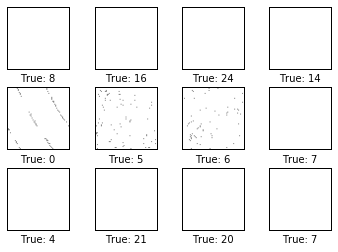

In [71]:
plot_img(data_x[0:12], y_int[0:12].flatten(), labels)

One of the interesting observation here is that it seems the salient features that compose the symbols of interest are all completly white (pixel rgb value of 255). It may be useful then as a pre-processing step to polarize the input data so to reduce the feature space into binary pixel values. The key would be to select a good threshold value.

### Data Metrics
Let's now look at some interesting metrics such as class representation. This is useful during data splitting to account for class imbalance, where we could use stratified sampling methods.

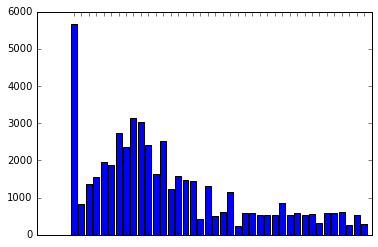

Possible output labels:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 24 25 27 28
 30 32 35 36 40 42 45 48 49 54 56 63 64 72 81]
Highest-count class representation 11.32%


In [72]:
classes_cnt = [len(data_y[data_y==v]) for _,v in enumerate(classes)]

fig, ax = plt.subplots()
ax.bar(np.arange(len(classes)), classes_cnt, align='center')
ax.set_xticks(np.arange(len(classes)))
ax.set_xticklabels([])
plt.show()

print('Possible output labels:')
print(classes)
print('Highest-count class representation %2.2f%%' % (max(classes_cnt)/sum(classes_cnt)*100))

## Data Splitting
Let us split the data into a 8:1:1 training, testing, validating set. We will use a stratified sampling scheme to combat the class imbalance noticed above.

The following is a class that wraps our data to get a nice next_batch() functionality. Credits goes to a Stackoverflow comment somewhere on the net.

In [73]:
class Dataset:

    def __init__(self,data):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._data = data
        self._num_examples = data.shape[0]
        pass

    def __len__(self):
        return self._num_examples

    @property
    def data(self):
        return self._data

    def next_batch(self,batch_size=None,shuffle=False):
        start = self._index_in_epoch
        if not batch_size:
            batch_size = self._num_examples
            
        if shuffle:
            idx0 = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx0)  # shuffle indexes
            self._data = self.data[idx0]  # get list of `num` random samples

        # go to the next batch
        if start + batch_size > self._num_examples:
            self._epochs_completed += 1
            rest_num_examples = self._num_examples - start
            data_rest_part = self.data[start:self._num_examples]

            start = 0
            self._index_in_epoch = batch_size - rest_num_examples #avoid the case where the #sample != integar times of batch_size
            end =  self._index_in_epoch  
            data_new_part =  self._data[start:end]  
            return np.concatenate((data_rest_part, data_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._data[start:end]

In [74]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(data_x, y_hot,
                                                      test_size=0.2, 
                                                      stratify=data_y,
                                                      random_state=SEED)
x_test, x_valid, y_test, y_valid = train_test_split(x_valid, y_valid,
                                                    test_size=0.5, 
                                                    stratify=np.argmax(y_valid, axis=1),
                                                    random_state=SEED)

In [75]:
x_train = Dataset(x_train)
y_train = Dataset(y_train)
x_test = Dataset(x_test)
y_test = Dataset(y_test)
x_valid = Dataset(x_valid)
y_valid = Dataset(y_valid)
print('Test: ', len(x_train), 'Valid: ', len(x_valid), 'Test: ', len(x_test))

Test:  40000 Valid:  5000 Test:  5000


Makinng sure the data is accessible correctly.

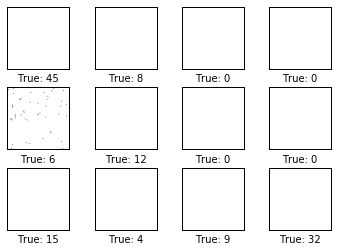

In [76]:
plot_img(x_train.data[0:12], np.argmax(y_train.data[0:12], axis=1), labels)

## GraphDef

#### ConvNet
Here we define the model's architecture along with all training hyperparameters. We will then test on each model a test set to obtain the best model and finally test against the held-out validation set.

### Define a reset function
Funny thing if you modify your nodes and rerun the jupyter block, TensorFlow will keep adding them as new ones to your graph, effectively growing your graph enormous! If you ever hit a GraphDef > 2GB error, you forgot to hit the reset button.

In [145]:
def reset_graph(session=None, seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    global total_iterations
    total_iterations = 0
    if session:
        if not session._closed:
            session.close()

reset_graph(seed=SEED)

### Hyperparameters

In [146]:
learning_rate = 0.001
dropout = 0.5
batch_size = 250

### Placeholders

In [147]:
x = tf.placeholder(tf.float32, shape=(None, IMG_SIZE, IMG_SIZE, IMG_CHANNELS), name="x")
y = tf.placeholder(tf.float32, shape=(None, NUM_CLASSES), name="y")
y_class = tf.cast(tf.argmax(y, axis=1), tf.int64)

### Architecture
We'll define the the convolutional neural network's architecture in layers.

In [148]:
with tf.variable_scope('ConvNet'):

    weight_init = tf.contrib.layers.xavier_initializer()

    # Convolution Layer with 32 filters and a kernel size of 5
    conv1 = tf.layers.conv2d(x, filters=16,  kernel_size=[5, 5], padding='Same', kernel_initializer=weight_init, activation=tf.nn.relu)
    pool1 = tf.sqrt(tf.layers.average_pooling2d(tf.square(conv1), 2, 2, padding='Same'))
    pool12 = tf.sqrt(tf.layers.average_pooling2d(tf.square(pool1), 2, 2, padding='Same'))

    conv2 = tf.layers.conv2d(pool1, filters=32, kernel_size=[7,7], padding='Same', kernel_initializer=weight_init, activation=tf.nn.relu)
    pool2 = tf.sqrt(tf.layers.average_pooling2d(tf.square(conv2), 2, 2, padding='Same'))

    # Flatten the data to a 1-D vector for the fully connected layer
    flat1 = tf.contrib.layers.flatten(pool12)
    flat2 = tf.contrib.layers.flatten(pool2)
    cat1 = tf.concat([flat1, flat2], axis=1)

    # Fully connected layer 
    fc1 = tf.layers.dense(cat1, 20, kernel_initializer=weight_init, activation=tf.nn.relu)

    # Apply Dropout 
    do1 = tf.layers.dropout(fc1, rate=dropout)

    logits = tf.layers.dense(do1, NUM_CLASSES)

### Learning
Defining the evaluation measures and the learning methods.

In [149]:
with tf.name_scope("loss"):
    cross = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(cross, name="loss")

In [150]:
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [151]:
with tf.name_scope("eval"):
    pred = tf.nn.softmax(logits)
    pred_class = tf.argmax(pred, axis=1)
    correct = tf.equal(pred_class, y_class)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## Training

In [152]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [153]:
def train(session, iterations, batch_size):
    global total_iterations
    #global train_acc_list
    #global valid_acc_list
    #global iterations_list
    print('Training Model.')
    
    time_start = time.time()

    for batch in range(iterations):
        x_batch = x_train.next_batch(batch_size)
        y_batch = y_train.next_batch(batch_size)
        session.run(training_op, feed_dict={x: x_batch, y: y_batch})   
        acc_train = accuracy.eval(session=session, feed_dict={x: x_batch, y: y_batch})
        acc_valid = accuracy.eval(session=session, feed_dict={x: x_valid.data, y: y_valid.data})
        
        #iterations_list += [(total_iterations + batch)]
        #train_acc_list += [acc_train]
        #valid_acc_list += [acc_valid]
        time_now = str(timedelta(seconds=int(round(time.time() - time_start))))
        
        #print(msg, total_iterations + batch, "Train accuracy:", acc_train*100, "Validation accuracy:", acc_valid*100)
        print('%s %4d\tTrain accuracy: %2.2f%%\tValidation accuracy: %2.2f%%' % (time_now, total_iterations + batch, acc_train*100, acc_valid*100))
    total_iterations += iterations
    print('Training Complete.')
    

In [ ]:
train(sess, iterations=160, batch_size=batch_size)

In [62]:
reset_graph(session=sess, seed=SEED)